# Apple Classifier - Transfer Learning with Multiple Models

This notebook implements an image classification system using various pre-trained CNN architectures.


## 1. Setup and Imports

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import (
    ResNet50, ResNet101, ResNet152, VGG16, VGG19, EfficientNetB0,
    Xception, InceptionV3, InceptionResNetV2, DenseNet121,
    MobileNetV2, NASNetMobile, NASNetLarge
)
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

2025-04-04 20:19:30.864905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 20:19:30.956368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 20:19:30.956433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 20:19:30.959408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 20:19:30.979444: I tensorflow/core/platform/cpu_feature_guar

## 2. Configuration

### GPU Configuration

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and enabled.")
else:
    print("No GPU found. Running on CPU.")

GPU is available and enabled.


2025-04-04 20:19:35.633662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:35.972708: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:35.972773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Parameters

In [3]:
dataset_dir = "dataset"
img_size = (224, 224)
batch_size = 32
epochs = 50
random_state = 42

## 3. Data Loading and Preprocessing

In [4]:
def load_dataset(dataset_path):
    images = []
    labels = []
    classes = os.listdir(dataset_path)

    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Loading class: {class_name}")

        for img_name in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(class_idx)

    return np.array(images), np.array(labels), classes

In [5]:
# Load and split dataset
X, y, class_names = load_dataset(dataset_dir)
print(f"Dataset loaded: {X.shape[0]} images across {len(class_names)} classes")

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)
print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
train_generator = train_datagen.flow(
    X_train, y_train, batch_size=batch_size
)

test_generator = test_datagen.flow(
    X_test, y_test, batch_size=batch_size
)

Loading class: Arjantin


100%|██████████| 21/21 [00:00<00:00, 156.30it/s]


Loading class: Buchkeygala


100%|██████████| 21/21 [00:00<00:00, 172.23it/s]


Loading class: Galaval


100%|██████████| 20/20 [00:01<00:00, 11.94it/s]


Loading class: Golden


100%|██████████| 21/21 [00:00<00:00, 272.63it/s]


Loading class: Joremin


100%|██████████| 21/21 [00:00<00:00, 263.94it/s]


Loading class: Superchief


100%|██████████| 21/21 [00:00<00:00, 221.66it/s]


Dataset loaded: 120 images across 6 classes
Training set: 96 images
Test set: 24 images


## 4. Model Creation Functions

### a. Transfer Learning Model Creation

In [6]:
def create_model(model_name, num_classes):
    model_constructors = {
        'resnet50': ResNet50,
        'resnet101': ResNet101,
        'resnet152': ResNet152,
        'vgg16': VGG16,
        'vgg19': VGG19,
        'efficientnet': EfficientNetB0,
        'xception': Xception,
        'inception': InceptionV3,
        'inceptionresnet': InceptionResNetV2,
        'densenet': DenseNet121,
        'mobilenet': MobileNetV2,
        'nasnetmobile': NASNetMobile,
        'nasnetlarge': NASNetLarge
    }

    # Get the constructor for the requested model
    model_constructor = model_constructors.get(model_name.lower())
    if model_constructor is None:
        raise ValueError(f"Unknown model name: {model_name}")

    # Create the base model
    base_model = model_constructor(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### b. Feature Extraction Model Creation

In [7]:
def extract_orb_features(images, n_features=100):
    features_list = []

    # Create ORB detector
    orb = cv2.ORB_create(nfeatures=n_features)

    for img in tqdm(images):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Detect keypoints and compute descriptors
        keypoints, descriptors = orb.detectAndCompute(gray, None)

        # Handle images with fewer features
        if descriptors is None or len(descriptors) < n_features:
            if descriptors is None:
                descriptors = np.zeros((n_features, 32), dtype=np.uint8)
            else:
                padding = np.zeros((n_features - len(descriptors), 32), dtype=np.uint8)
                descriptors = np.vstack((descriptors, padding))
        else:
            # Sample if more features found
            indices = np.random.choice(len(descriptors), n_features, replace=False)
            descriptors = descriptors[indices]

        # Flatten the descriptor to create a feature vector
        features_list.append(descriptors.flatten())

    return np.array(features_list)


# 5. Model Training and Evaluation


a. Transfer Learning Models

In [8]:
def train_and_evaluate_model(model_name, num_classes):
    """Train, evaluate and save a model"""
    print(f"\n{'=' * 20} Training {model_name} {'=' * 20}")

    # Create the model
    model = create_model(model_name, num_classes)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        verbose=1
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test / 255.0, y_test, verbose=1)
    print(f"{model_name} Test accuracy: {test_acc:.4f}")

    # Save the model
    model.save(f"saved_models/apple_classifier_{model_name.lower()}.h5")
    print(f"{model_name} model saved successfully")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.tight_layout()

    plt.suptitle(f'{model_name} Training History', fontsize=16)
    plt.subplots_adjust(top=0.85)  # Adjust title position

    # Save the plot BEFORE showing it
    plt.savefig(f"plots/apple_classifier_{model_name.lower()}_history.png")
    plt.show()

    return model, history, test_acc


==================== Training ResNet50 ====================


2025-04-04 20:19:38.883577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:38.883660: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:38.883679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:39.066649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-04 20:19:39.066723: I external/local_xla/xla/stream_executor

Epoch 1/50


2025-04-04 20:19:43.007658: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-04 20:19:43.169511: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-04 20:19:44.262319: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/3 [=========>....................] - ETA: 8s - loss: 1.9415 - accuracy: 0.1875

2025-04-04 20:19:45.324731: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f56106bb7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-04 20:19:45.324768: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-04-04 20:19:45.331502: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743787185.406590  226390 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 8s 2s/step - loss: 1.9170 - accuracy: 0.1667 - val_loss: 1.8250 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 232ms/step - loss: 1.8134 - accuracy: 0.1458 - val_loss: 1.8204 - val_accuracy: 0.2500
Epoch 3/50
3/3 [==============================] - 1s 239ms/step - loss: 1.8155 - accuracy: 0.1667 - val_loss: 1.8244 - val_accuracy: 0.1667
Epoch 4/50
3/3 [==============================] - 1s 231ms/step - loss: 1.8208 - accuracy: 0.1771 - val_loss: 1.8164 - val_accuracy: 0.1250
Epoch 5/50
3/3 [==============================] - 1s 227ms/step - loss: 1.8028 - accuracy: 0.1979 - val_loss: 1.8017 - val_accuracy: 0.1667
Epoch 6/50
3/3 [==============================] - 1s 224ms/step - loss: 1.8072 - accuracy: 0.1354 - val_loss: 1.8059 - val_accuracy: 0.1667
Epoch 7/50
3/3 [==============================] - 1s 225ms/step - loss: 1.8016 - accuracy: 0.1979 - val_loss: 1.8057 - val_accuracy: 0.2083
Epoch 8/50
3/3 [==================

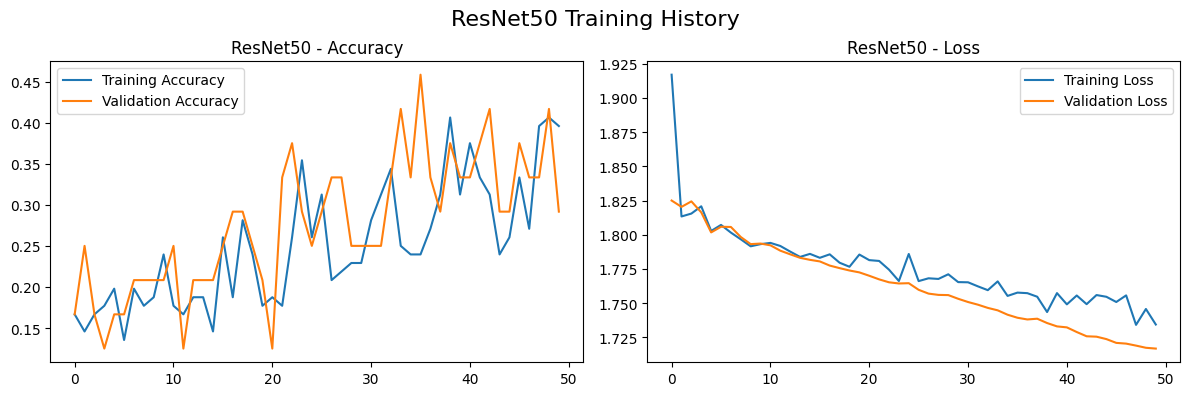


==================== Training VGG16 ====================
Epoch 1/50


2025-04-04 20:20:30.705987: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-04 20:20:30.706108: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-04 20:20:30.706127: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-04 20:20:30.786092: W external/local_tsl/tsl/framewor

3/3 [==============================] - 13s 3s/step - loss: 2.0000 - accuracy: 0.1667 - val_loss: 1.9166 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 282ms/step - loss: 1.8855 - accuracy: 0.1667 - val_loss: 1.8406 - val_accuracy: 0.1667
Epoch 3/50
3/3 [==============================] - 1s 270ms/step - loss: 1.8268 - accuracy: 0.1667 - val_loss: 1.7954 - val_accuracy: 0.1667
Epoch 4/50
3/3 [==============================] - 1s 272ms/step - loss: 1.8026 - accuracy: 0.1667 - val_loss: 1.7757 - val_accuracy: 0.2083
Epoch 5/50
3/3 [==============================] - 1s 253ms/step - loss: 1.7960 - accuracy: 0.1354 - val_loss: 1.7694 - val_accuracy: 0.2500
Epoch 6/50
3/3 [==============================] - -1s 266ms/step - loss: 1.7793 - accuracy: 0.1771 - val_loss: 1.7662 - val_accuracy: 0.3333
Epoch 7/50
3/3 [==============================] - 1s 274ms/step - loss: 1.7696 - accuracy: 0.2708 - val_loss: 1.7619 - val_accuracy: 0.4167
Epoch 8/50
3/3 [================

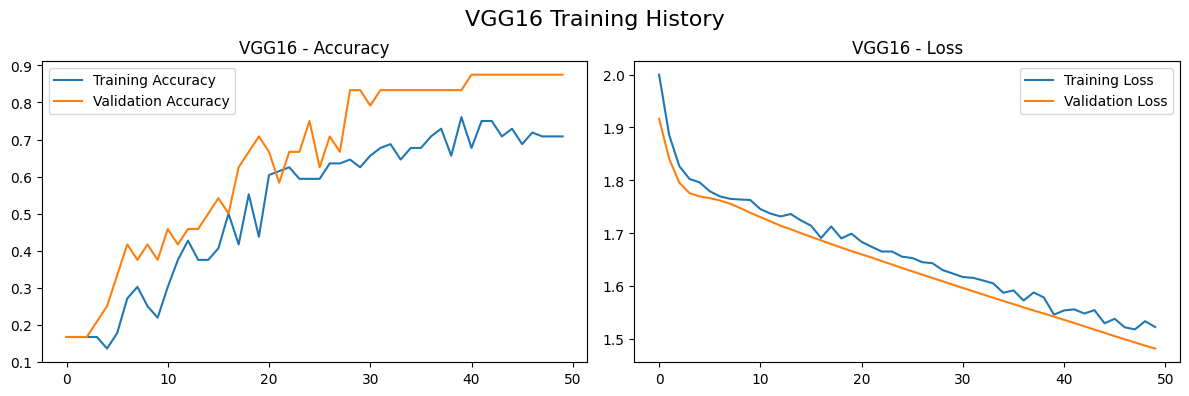


==================== Training EfficientNet ====================
Epoch 1/50
3/3 [==============================] - 7s 690ms/step - loss: 1.8269 - accuracy: 0.1771 - val_loss: 1.7962 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 253ms/step - loss: 1.7910 - accuracy: 0.1979 - val_loss: 1.7971 - val_accuracy: 0.1667
Epoch 3/50
3/3 [==============================] - 1s 308ms/step - loss: 1.8091 - accuracy: 0.1562 - val_loss: 1.7993 - val_accuracy: 0.1667
Epoch 4/50
3/3 [==============================] - 1s 258ms/step - loss: 1.8055 - accuracy: 0.1146 - val_loss: 1.7985 - val_accuracy: 0.1667
Epoch 5/50
3/3 [==============================] - 1s 223ms/step - loss: 1.7921 - accuracy: 0.1458 - val_loss: 1.7959 - val_accuracy: 0.1667
Epoch 6/50
3/3 [==============================] - 1s 225ms/step - loss: 1.8085 - accuracy: 0.1354 - val_loss: 1.7965 - val_accuracy: 0.1667
Epoch 7/50
3/3 [==============================] - 1s 219ms/step - loss: 1.8031 - accuracy: 0.14

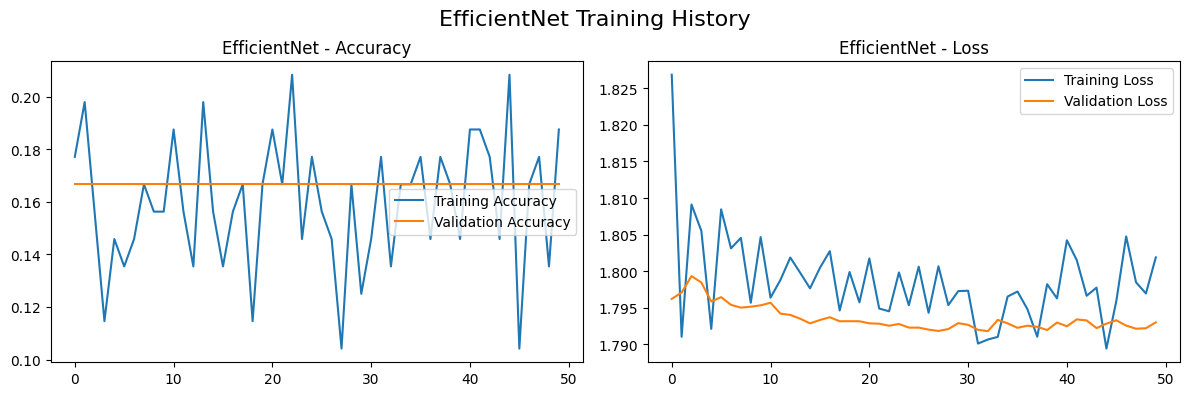


==================== Training Xception ====================
Epoch 1/50
3/3 [==============================] - 6s 1s/step - loss: 1.8327 - accuracy: 0.2083 - val_loss: 1.6304 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 1s 243ms/step - loss: 1.6479 - accuracy: 0.3333 - val_loss: 1.4938 - val_accuracy: 0.4583
Epoch 3/50
3/3 [==============================] - 1s 222ms/step - loss: 1.4905 - accuracy: 0.4896 - val_loss: 1.3531 - val_accuracy: 0.6250
Epoch 4/50
3/3 [==============================] - 1s 229ms/step - loss: 1.3426 - accuracy: 0.6354 - val_loss: 1.2319 - val_accuracy: 0.7500
Epoch 5/50
3/3 [==============================] - -1s 224ms/step - loss: 1.2214 - accuracy: 0.7604 - val_loss: 1.1336 - val_accuracy: 0.7500
Epoch 6/50
3/3 [==============================] - 1s 235ms/step - loss: 1.1379 - accuracy: 0.7500 - val_loss: 1.0547 - val_accuracy: 0.7500
Epoch 7/50
3/3 [==============================] - 1s 227ms/step - loss: 1.0721 - accuracy: 0.7396 - v

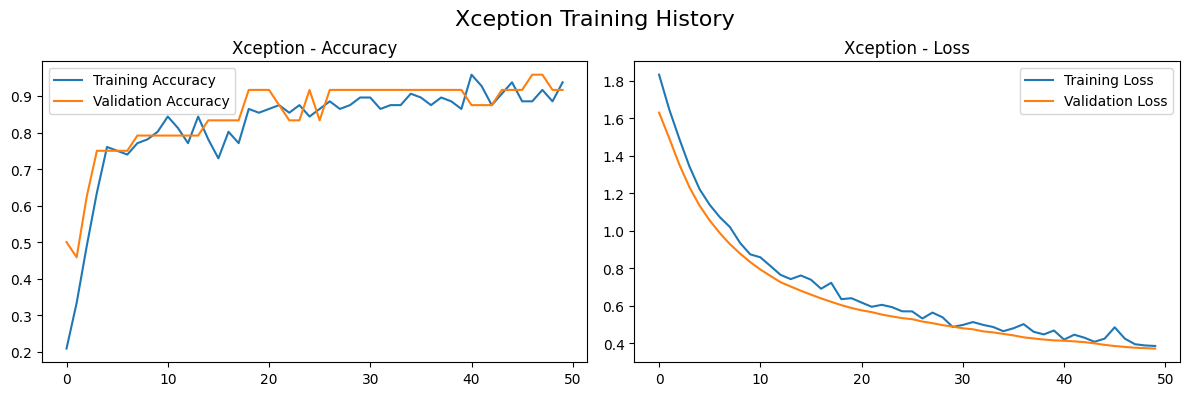


==================== Training Inception ====================
Epoch 1/50
3/3 [==============================] - 15s 3s/step - loss: 1.8249 - accuracy: 0.2500 - val_loss: 1.6530 - val_accuracy: 0.2083
Epoch 2/50
3/3 [==============================] - 1s 203ms/step - loss: 1.6699 - accuracy: 0.3125 - val_loss: 1.4748 - val_accuracy: 0.4583
Epoch 3/50
3/3 [==============================] - 1s 217ms/step - loss: 1.3888 - accuracy: 0.5000 - val_loss: 1.3213 - val_accuracy: 0.5417
Epoch 4/50
3/3 [==============================] - 1s 211ms/step - loss: 1.2735 - accuracy: 0.5417 - val_loss: 1.2249 - val_accuracy: 0.5833
Epoch 5/50
3/3 [==============================] - 1s 209ms/step - loss: 1.0703 - accuracy: 0.6562 - val_loss: 1.0743 - val_accuracy: 0.4583
Epoch 6/50
3/3 [==============================] - 1s 208ms/step - loss: 1.0457 - accuracy: 0.6771 - val_loss: 0.9867 - val_accuracy: 0.6250
Epoch 7/50
3/3 [==============================] - 1s 201ms/step - loss: 0.9393 - accuracy: 0.6667 - 

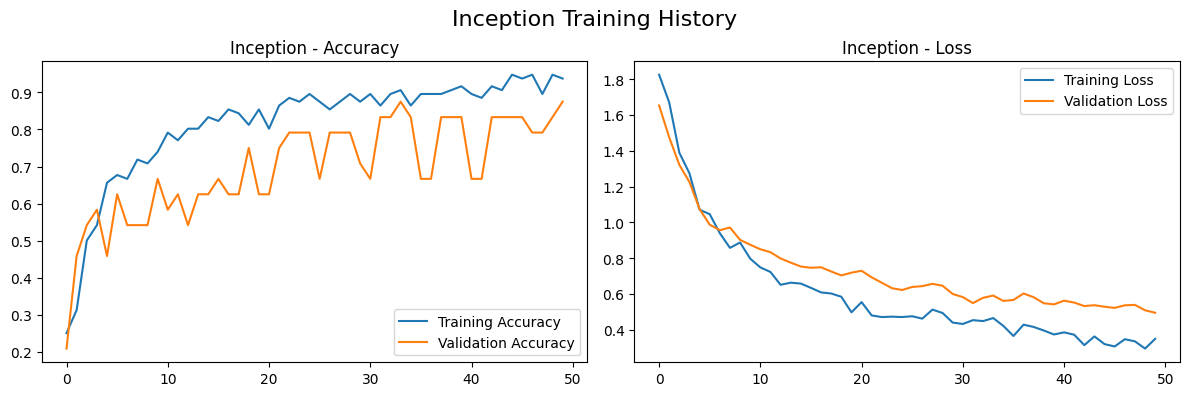


==================== Training DenseNet ====================
Epoch 1/50
3/3 [==============================] - 7s 1s/step - loss: 1.8996 - accuracy: 0.2083 - val_loss: 1.7023 - val_accuracy: 0.4167
Epoch 2/50
3/3 [==============================] - 1s 243ms/step - loss: 1.6457 - accuracy: 0.3542 - val_loss: 1.5284 - val_accuracy: 0.3750
Epoch 3/50
3/3 [==============================] - 1s 233ms/step - loss: 1.4879 - accuracy: 0.3958 - val_loss: 1.3886 - val_accuracy: 0.4167
Epoch 4/50
3/3 [==============================] - 1s 226ms/step - loss: 1.3808 - accuracy: 0.4479 - val_loss: 1.2791 - val_accuracy: 0.5417
Epoch 5/50
3/3 [==============================] - 1s 220ms/step - loss: 1.3031 - accuracy: 0.4688 - val_loss: 1.1796 - val_accuracy: 0.7083
Epoch 6/50
3/3 [==============================] - 1s 228ms/step - loss: 1.2417 - accuracy: 0.5625 - val_loss: 1.1145 - val_accuracy: 0.6667
Epoch 7/50
3/3 [==============================] - 1s 234ms/step - loss: 1.1074 - accuracy: 0.5833 - va

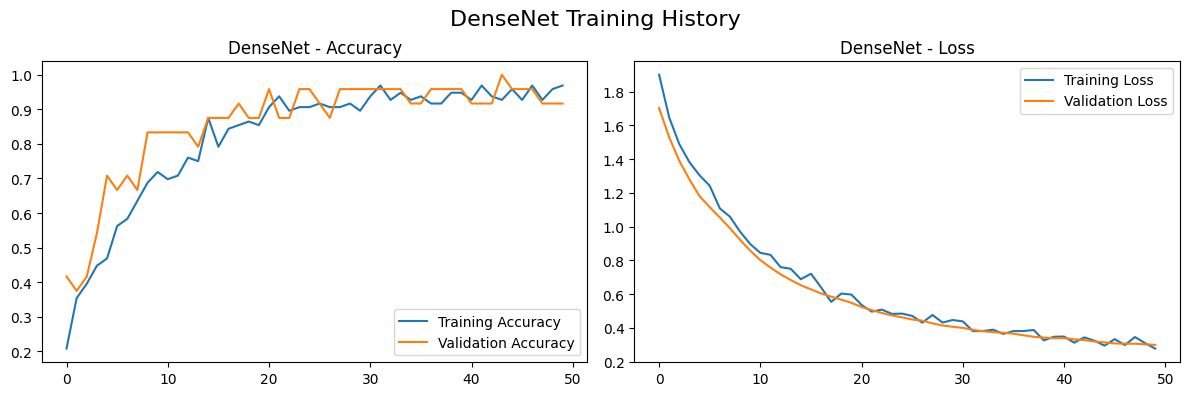


==================== Training MobileNet ====================
Epoch 1/50
3/3 [==============================] - 3s 565ms/step - loss: 1.9644 - accuracy: 0.2292 - val_loss: 1.7490 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - 1s 227ms/step - loss: 1.5496 - accuracy: 0.4062 - val_loss: 1.4565 - val_accuracy: 0.5833
Epoch 3/50
3/3 [==============================] - 1s 205ms/step - loss: 1.3188 - accuracy: 0.5000 - val_loss: 1.2502 - val_accuracy: 0.5833
Epoch 4/50
3/3 [==============================] - 1s 202ms/step - loss: 1.1079 - accuracy: 0.6771 - val_loss: 1.0686 - val_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 1s 213ms/step - loss: 0.9313 - accuracy: 0.8021 - val_loss: 0.9125 - val_accuracy: 0.8333
Epoch 6/50
3/3 [==============================] - 1s 209ms/step - loss: 0.8230 - accuracy: 0.8542 - val_loss: 0.8073 - val_accuracy: 0.8333
Epoch 7/50
3/3 [==============================] - 1s 199ms/step - loss: 0.7259 - accuracy: 0.8438 

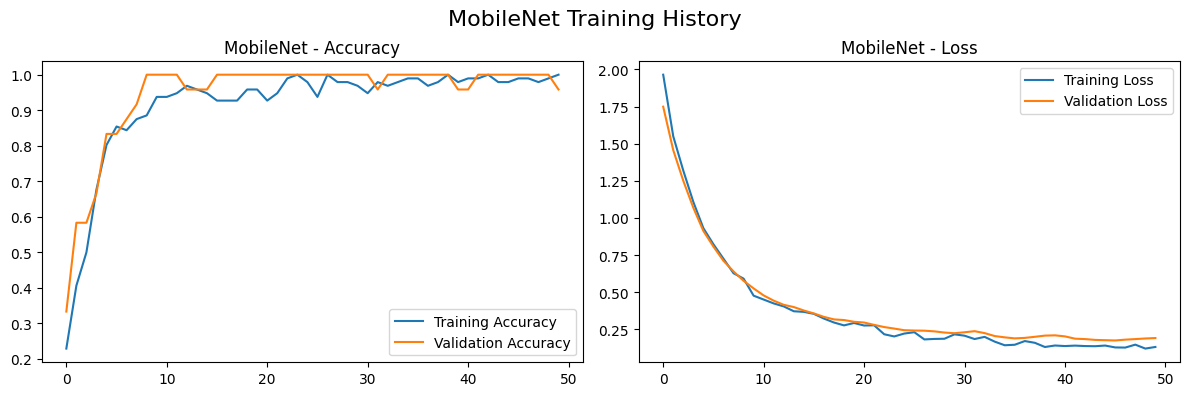


==================== Training ResNet101 ====================
Epoch 1/50
3/3 [==============================] - 6s 811ms/step - loss: 1.8632 - accuracy: 0.1146 - val_loss: 1.8107 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 295ms/step - loss: 1.8093 - accuracy: 0.1562 - val_loss: 1.7957 - val_accuracy: 0.1667
Epoch 3/50
3/3 [==============================] - 1s 299ms/step - loss: 1.7972 - accuracy: 0.2083 - val_loss: 1.7992 - val_accuracy: 0.1667
Epoch 4/50
3/3 [==============================] - 1s 287ms/step - loss: 1.7961 - accuracy: 0.1771 - val_loss: 1.7977 - val_accuracy: 0.1667
Epoch 5/50
3/3 [==============================] - -1s -538960us/step - loss: 1.7977 - accuracy: 0.1667 - val_loss: 1.7856 - val_accuracy: 0.1667
Epoch 6/50
3/3 [==============================] - 1s 291ms/step - loss: 1.7745 - accuracy: 0.1771 - val_loss: 1.7767 - val_accuracy: 0.3333
Epoch 7/50
3/3 [==============================] - 1s 293ms/step - loss: 1.7921 - accuracy: 0.

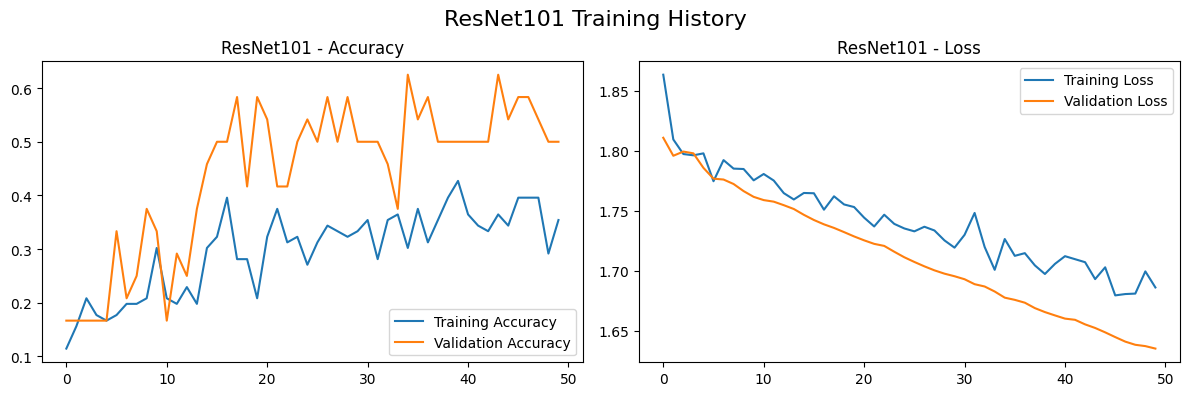


==================== Training ResNet152 ====================
Epoch 1/50
3/3 [==============================] - 9s 1s/step - loss: 1.9579 - accuracy: 0.1146 - val_loss: 1.8558 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 414ms/step - loss: 1.8290 - accuracy: 0.1667 - val_loss: 1.8164 - val_accuracy: 0.1667
Epoch 3/50
3/3 [==============================] - 1s 408ms/step - loss: 1.8223 - accuracy: 0.1562 - val_loss: 1.8152 - val_accuracy: 0.1667
Epoch 4/50
3/3 [==============================] - 1s 401ms/step - loss: 1.8110 - accuracy: 0.1875 - val_loss: 1.8111 - val_accuracy: 0.1667
Epoch 5/50
3/3 [==============================] - -0s 402ms/step - loss: 1.8220 - accuracy: 0.1667 - val_loss: 1.7994 - val_accuracy: 0.1667
Epoch 6/50
3/3 [==============================] - 1s 406ms/step - loss: 1.8151 - accuracy: 0.1667 - val_loss: 1.7846 - val_accuracy: 0.1667
Epoch 7/50
3/3 [==============================] - 1s 399ms/step - loss: 1.7930 - accuracy: 0.1562 - 

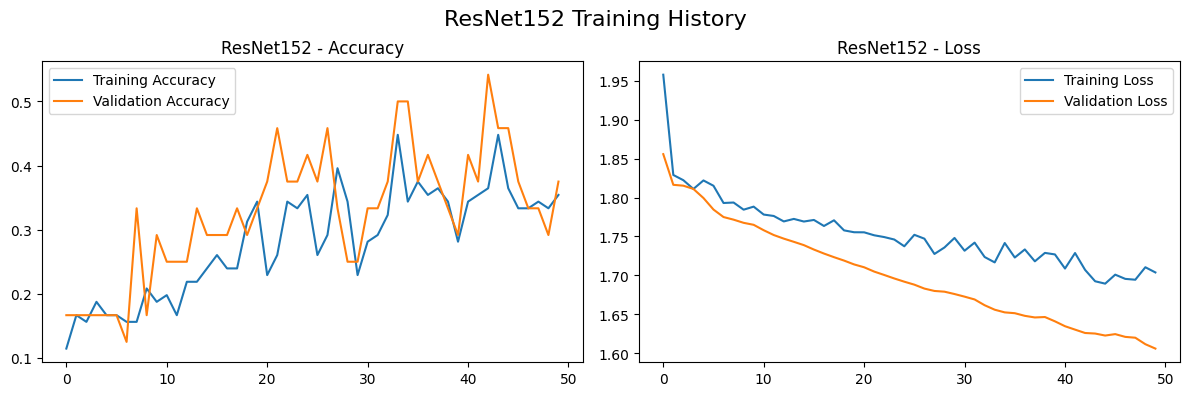


==================== Training VGG19 ====================
Epoch 1/50
3/3 [==============================] - 2s 359ms/step - loss: 2.0334 - accuracy: 0.1667 - val_loss: 1.9389 - val_accuracy: 0.1667
Epoch 2/50
3/3 [==============================] - 1s 285ms/step - loss: 1.9173 - accuracy: 0.1667 - val_loss: 1.8479 - val_accuracy: 0.1667
Epoch 3/50
3/3 [==============================] - -1s -529714us/step - loss: 1.8426 - accuracy: 0.1667 - val_loss: 1.7958 - val_accuracy: 0.2083
Epoch 4/50
3/3 [==============================] - 1s 290ms/step - loss: 1.7978 - accuracy: 0.2188 - val_loss: 1.7702 - val_accuracy: 0.2500
Epoch 5/50
3/3 [==============================] - 1s 294ms/step - loss: 1.7797 - accuracy: 0.2292 - val_loss: 1.7587 - val_accuracy: 0.1667
Epoch 6/50
3/3 [==============================] - 1s 285ms/step - loss: 1.7482 - accuracy: 0.2708 - val_loss: 1.7551 - val_accuracy: 0.2500
Epoch 7/50
3/3 [==============================] - 1s 288ms/step - loss: 1.7566 - accuracy: 0.2500

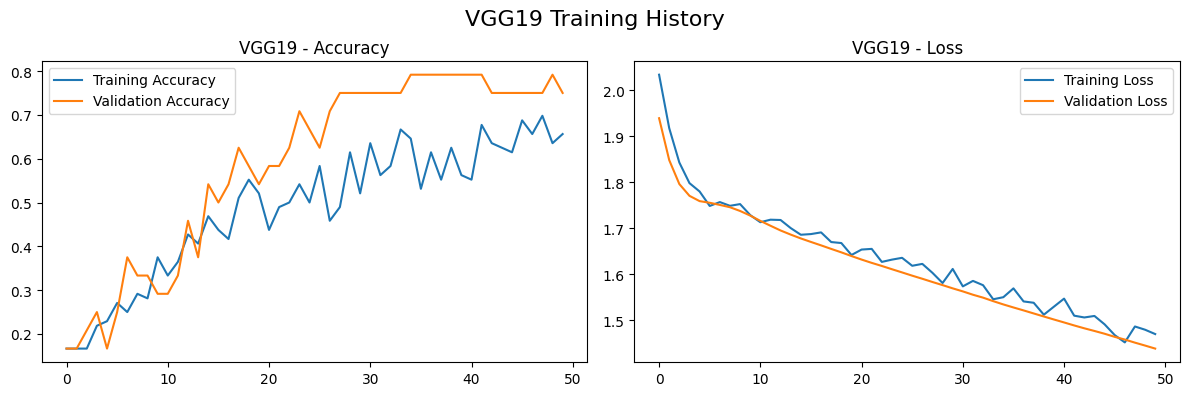


==================== Training InceptionResNetV2 ====================
Error training InceptionResNetV2: Unknown model name: InceptionResNetV2

==================== Training NASNetMobile ====================
Epoch 1/50
3/3 [==============================] - 11s 1s/step - loss: 1.8613 - accuracy: 0.2083 - val_loss: 1.7424 - val_accuracy: 0.4583
Epoch 2/50
3/3 [==============================] - 1s 195ms/step - loss: 1.6736 - accuracy: 0.3125 - val_loss: 1.6064 - val_accuracy: 0.3750
Epoch 3/50
3/3 [==============================] - 1s 220ms/step - loss: 1.5192 - accuracy: 0.4062 - val_loss: 1.4991 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - -1s -604065us/step - loss: 1.4428 - accuracy: 0.4583 - val_loss: 1.3994 - val_accuracy: 0.6250
Epoch 5/50
3/3 [==============================] - 1s 217ms/step - loss: 1.3530 - accuracy: 0.5312 - val_loss: 1.3114 - val_accuracy: 0.6250
Epoch 6/50
3/3 [==============================] - 1s 225ms/step - loss: 1.2348 - accuracy:

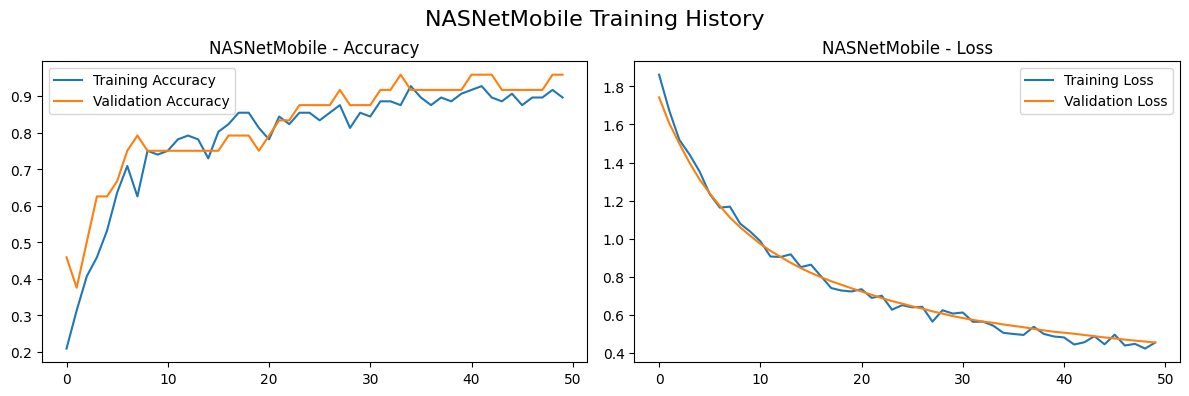


==================== Training NASNetLarge ====================
Epoch 1/50
3/3 [==============================] - 15s 2s/step - loss: 1.8727 - accuracy: 0.1562 - val_loss: 1.6287 - val_accuracy: 0.2917
Epoch 2/50
3/3 [==============================] - 2s 571ms/step - loss: 1.5257 - accuracy: 0.3438 - val_loss: 1.4141 - val_accuracy: 0.4167
Epoch 3/50
3/3 [==============================] - 2s 568ms/step - loss: 1.2825 - accuracy: 0.5000 - val_loss: 1.2787 - val_accuracy: 0.4583
Epoch 4/50
3/3 [==============================] - 2s 566ms/step - loss: 1.1696 - accuracy: 0.5208 - val_loss: 1.1682 - val_accuracy: 0.5417
Epoch 5/50
3/3 [==============================] - -0s 564ms/step - loss: 1.1274 - accuracy: 0.5417 - val_loss: 1.0628 - val_accuracy: 0.6250
Epoch 6/50
3/3 [==============================] - 2s 570ms/step - loss: 1.0218 - accuracy: 0.7083 - val_loss: 1.0063 - val_accuracy: 0.6250
Epoch 7/50
3/3 [==============================] - 2s 566ms/step - loss: 0.9594 - accuracy: 0.6667

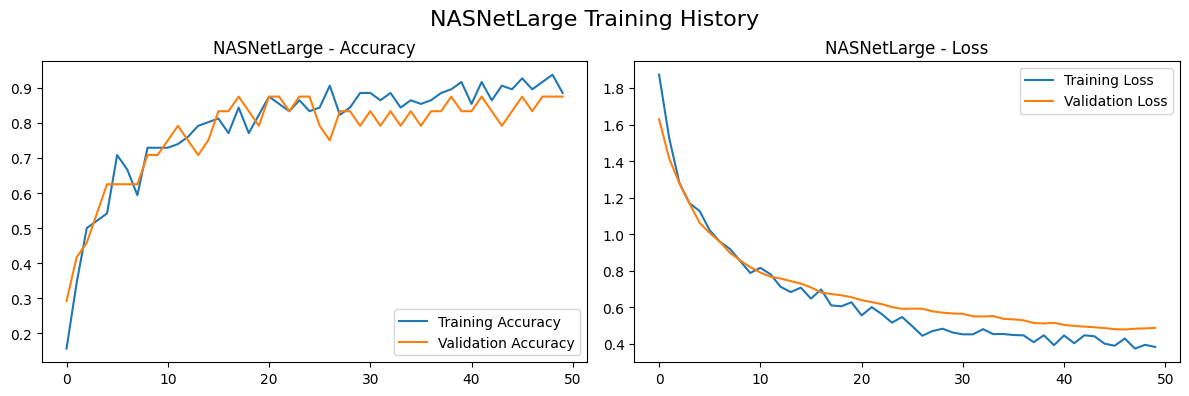

In [9]:
# List of models to train
models_to_train = [
    'ResNet50',
    'VGG16',
    'EfficientNet',
    'Xception',
    'Inception',
    'DenseNet',
    'MobileNet',
    'ResNet101',
    'ResNet152',
    'VGG19',
    'InceptionResNetV2',
    'NASNetMobile',
    'NASNetLarge'
]
# Dictionary to store results for comparison
results_transfer = {}

# Train each model
for model_name in models_to_train:
    try:
        model, history, accuracy = train_and_evaluate_model(model_name, len(class_names))
        results_transfer[model_name] = {
            'accuracy': accuracy,
            'history': history
        }
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        continue

### b. Feature Extraction and Classifier Training

In [10]:
# Extract ORB features
X_train_orb = extract_orb_features(X_train)
X_test_orb = extract_orb_features(X_test)

Extracting ORB features...


100%|██████████| 96/96 [00:00<00:00, 629.36it/s]


Extracting ORB features...


100%|██████████| 24/24 [00:00<00:00, 1409.14it/s]


In [11]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_type, class_names):
    """Train and evaluate multiple ML models with 5-fold cross-validation"""
    # Define classifiers
    classifiers = {
        'SVM': SVC(probability=True, random_state=random_state),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state),
        'Neural Network': MLPClassifier(random_state=random_state, max_iter=1000),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state=random_state),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'XGBoost': xgb.XGBClassifier(random_state=random_state),
        'Extra Trees': ExtraTreesClassifier(random_state=random_state),
        'Bagging': BaggingClassifier(random_state=random_state),
        'SGD Classifier': SGDClassifier(max_iter=1000, random_state=random_state),
        'Gaussian NB': GaussianNB(),
        'Bernoulli NB': BernoulliNB()
    }

    results = {}

    for name, clf in classifiers.items():
        print(f"\n{'=' * 20} Training {name} with {feature_type} features {'=' * 20}")

        # Perform 5-fold cross-validation
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # Train on full training set
        clf.fit(X_train, y_train)

        # Predict on test set
        y_pred = clf.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {test_acc:.4f}")

        # Classification report
        report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

        # Save results
        results[name] = {
            'cv_accuracy': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': test_acc,
            'report': report,
            'model': clf
        }

    return results

In [12]:
# Train models with ORB features
orb_results = train_and_evaluate_models(
    X_train_orb, X_test_orb, y_train, y_test, 'ORB', class_names
)


==================== Training SVM with ORB features ====================
Cross-validation accuracy: 0.3426 ± 0.1134
Test accuracy: 0.4583

==================== Training KNN with ORB features ====================
Cross-validation accuracy: 0.4379 ± 0.0302
Test accuracy: 0.2917

==================== Training Decision Tree with ORB features ====================
Cross-validation accuracy: 0.4263 ± 0.0855
Test accuracy: 0.3750

==================== Training Random Forest with ORB features ====================
Cross-validation accuracy: 0.4168 ± 0.0820
Test accuracy: 0.4167

==================== Training Neural Network with ORB features ====================
Cross-validation accuracy: 0.2700 ± 0.0989
Test accuracy: 0.2083

==================== Training Logistic Regression with ORB features ====================
Cross-validation accuracy: 0.3537 ± 0.1199
Test accuracy: 0.2083

==================== Training Gradient Boosting with ORB features ====================
Cross-validation accuracy: 0.33

# 6. Results and Comparison

### a. Transfer Learning Models

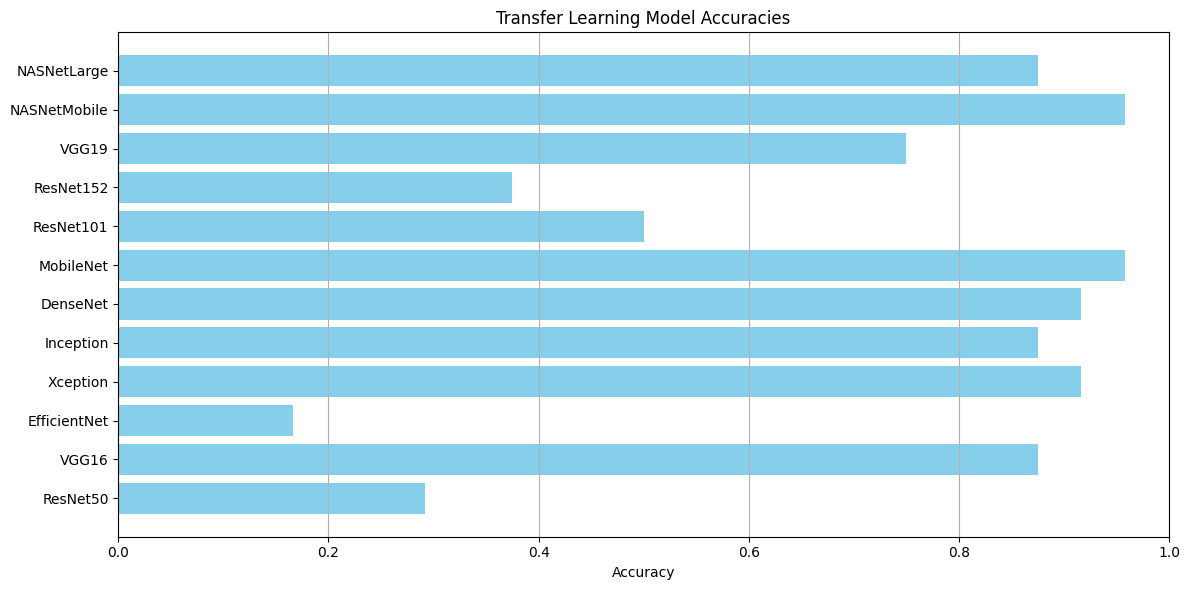

In [13]:
# Plot and save results for transfer learning models
def plot_transfer_learning_results(results):
    plt.figure(figsize=(12, 6))
    accuracies = [result['accuracy'] for result in results.values()]
    model_names = list(results.keys())
    plt.barh(model_names, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Transfer Learning Model Accuracies')
    plt.xlim(0, 1)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

plot_transfer_learning_results(results_transfer)

### b. Feature Extraction Models

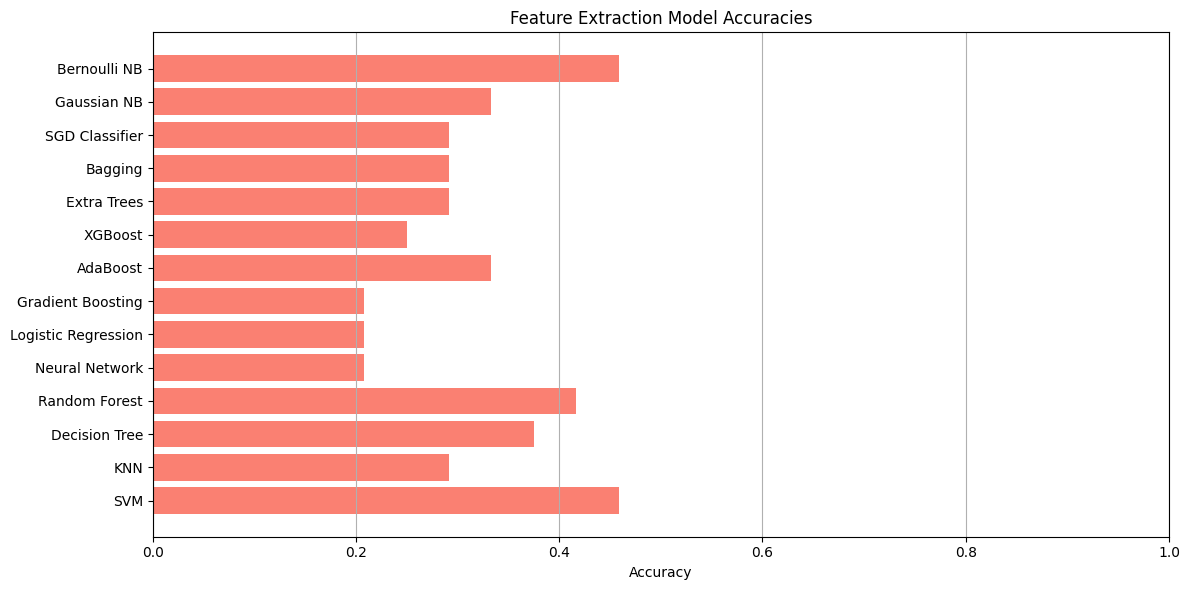

In [14]:
# Plot and save results for feature extraction models
def plot_feature_extraction_results(results):
    plt.figure(figsize=(12, 6))
    accuracies = [result['test_accuracy'] for result in results.values()]
    model_names = list(results.keys())
    plt.barh(model_names, accuracies, color='salmon')
    plt.xlabel('Accuracy')
    plt.title('Feature Extraction Model Accuracies')
    plt.xlim(0, 1)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

plot_feature_extraction_results(orb_results)
